#[Part 2] Hate speech Detection using Neural Learning Models
In this notebook, we conduct a preliminary experiment on the detection of hate speech in Arabic tweets as part of our participation in the Hate Speech Detection subtask in [OSACT4 workshop](http://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/).

We experimented with three types of neural models:
### 1.   Recurrent Neural Networks (RNN):
>*   Long Short-Term Memory (LSTM)
>*   Bidirectional LSTM (BLSTM)
>*   Gated Recurrent Unit (GRU)


### 2.   Convolutional Neural Networks (CNN)

### 3.   Combined CNN-RNN:
>* CNN-LSTM
>* CNN-BLSTM
>* CNN-GRU
>* CNN-LSTM with overSampling




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback
from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)


# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [ ]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/My Drive/tweets_sg_300.zip'  

Archive:  /content/drive/My Drive/tweets_sg_300.zip
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [ ]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/train_data.csv')
train_data

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6995,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6996,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6997,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6998,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [ ]:
dev_data = pd.read_csv('/content/drive/My Drive/dev_data.csv')
dev_data

,Tweet,Offensive,Hate
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS
...,...,...,...
995,RT @USER: انتو بتوزعوا زيت وسكر فعلا يا عباس؟<...,NOT_OFF,NOT_HS
996,RT @USER: كدا يا عمر متزعلهاش يا حبيبي 😂 URL,NOT_OFF,NOT_HS
997,هدا سكن اطفال امارتين من شارقة طالبين فزعتكم ي...,NOT_OFF,NOT_HS
998,RT @USER: ومدني بمدد من قوتك أواجه به ضعفي.. و...,NOT_OFF,NOT_HS


In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/Test_data.csv')
test_data

,Tweet,Offensive,Hate
0,@USER اما انت تقعد طول عمرك لا مبدا ولا راي ثا...,OFF,HS
1,@USER @USER بتخاف نسوانك يزعلوا ولا ايه 😂 اه ي...,OFF,NOT_HS
2,RT @USER: يا عـسانـى نـبـقى يا عـمري حـبايـب و...,NOT_OFF,NOT_HS
3,RT @USER: باقي البيان وينو ما شفنه يا برهان <L...,OFF,NOT_HS
4,@USER @USER اللهم انت الشافي المعافي اشفيه وجم...,NOT_OFF,NOT_HS
...,...,...,...
1995,RT @USER: الله لايوفقك يا مهند عسيري يا معوق و...,OFF,NOT_HS
1996,RT @USER: @USER حبيبي يا يوسف وانت طيب يا صاحب...,NOT_OFF,NOT_HS
1997,RT @USER: يا بو محمد عشت يا طيب الفال<LF>عاشت ...,NOT_OFF,NOT_HS
1998,أنا مستني الحلقة بقالي سنتين يا بضان يا ابن ال...,OFF,NOT_HS


In [ ]:
print("Train data shape: {} \nDev data shape: {}".format(train_data.shape,dev_data.shape))


Train data shape: (7000, 3) 
Dev data shape: (1000, 3)


In [ ]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[2].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, dev_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    dev_tokenized = tokenizer.texts_to_sequences(dev_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(dev_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train,x_dev, x_test, y_train,y_dev, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_dev = y_encoder.transform(y_dev)
    y_test = y_encoder.transform(y_test)

    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_dev, x_vec_test, word_index = get_train_test(x_train,x_dev, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of dev examples: ' + str(len(x_vec_test)))
    return x_vec_train,x_vec_dev, x_vec_test, y_train, y_dev, y_test, train_y_cat, word_index


In [ ]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

Number of words in the word embedding 331679


In [ ]:
# load train data
train_data_path=["/content/drive/My Drive/synonyms_remove.csv"]
x_train, y_train, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 84
Label categories: ['HS' 'NOT_HS']


In [ ]:
# load dev data
dev_data_path=["/content/drive/My Drive/dev_data_cleaned.csv"]
x_dev, y_dev, MAX_TEXT_LENGTH = load_datasets(dev_data_path)
CLASSES_LIST = np.unique(y_dev)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 72
Label categories: ['HS' 'NOT_HS']


In [ ]:
# load test data
test_data_path=["/content/drive/My Drive/test_data_cleaned.csv"]
x_test, y_test, MAX_TEXT_LENGTH = load_datasets(test_data_path)
CLASSES_LIST = np.unique(y_test)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 72
Label categories: ['HS' 'NOT_HS']


In [ ]:
MAX_TEXT_LENGTH=84

In [ ]:
x_train, x_dev,x_test, y_train, y_dev, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_dev,x_test, 
                                                                            y_train, y_dev,y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
dev_cat_y = np_utils.to_categorical(y_dev, len(CLASSES_LIST))
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 9002
Number of dev examples: 2000


In [ ]:
print("Tokens number: "+str(len(word_index)))

Tokens number: 30591


In [ ]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))


Original sequence length: 84


In [ ]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
def get_model(embedding_weights, word_index, vocab_dim, max_length,layer, dropout, optimizer, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = layer(model)
    model = Dropout(dropout)(model)       
    model = Flatten()(model)
    model = Dense(2, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                   layer, dropout,optimizer):
   
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, 
                      layer, dropout, optimizer= optimizer ,print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_dev, y_train, y_dev,class_weight, batch_size, epochs, TestCallback=TestCallback):
   
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_dev, y_dev),
                        class_weight=class_weight,
                        callbacks=[TestCallback((x_dev, y_dev)),early_stopping])
    return history, model

#### Note: the prior work is the same for all of the neural learning models.

#  RNN (LSTM) Model

In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= LSTM(units=16, return_sequences=True, return_state=False), dropout=0.5, 
                       optimizer= optimizers.Adam(0.001))

Building embedding matrix...
Embedding matrix built.
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 84)]              0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 84, 300)           9177600   
_________________________________________________________________
lstm_17 (LSTM)               (None, 84, 16)            20288     
_________________________________________________________________
dropout_23 (Dropout)         (None, 84, 16)            0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 2690      
Total params: 9,200,578
Trainable params: 22,978
Non-trainable params: 

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y, class_weight=None,
                               batch_size=500, epochs=15)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/15
19/19 [==============================] - 6s 207ms/step - loss: 0.6436 - accuracy: 0.6412 - val_loss: 0.2681 - val_accuracy: 0.9480

Testing loss: 0.2680942714214325, acc: 0.9480000138282776

Epoch 2/15
19/19 [==============================] - 4s 197ms/step - loss: 0.4598 - accuracy: 0.7855 - val_loss: 0.2153 - val_accuracy: 0.9340

Testing loss: 0.21534624695777893, acc: 0.9340000152587891

Epoch 3/15
19/19 [==============================] - 4s 195ms/step - loss: 0.3301 - accuracy: 0.8435 - val_loss: 0.2031 - val_accuracy: 0.9220

Testing loss: 0.2031441330909729, acc: 0.921999990940094

Epoch 4/15
19/19 [==============================] - 4s 192ms/step - loss: 0.2853 - accuracy: 0.8759 - val_loss: 0.1431 - val_accuracy: 0.9480

Testing loss: 0.14307817816734314, acc: 0.9480000138282776

Epoch 5/15
19/19 [==============================] - 4s 204ms/step - loss: 0.2759 - accuracy: 0.8721 - val_loss: 0.1599 - val_accuracy: 0.9370

Testing loss: 0.15994077920913696, acc: 0.936999

In [ ]:
history.history.keys()

In [ ]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)


In [ ]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

In [ ]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

In [ ]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

In [ ]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 5
Accuracy on train : 89.58 %
Accuracy on val : 94.9 %
Loss on train : 23.34
Loss on Val : 13.59


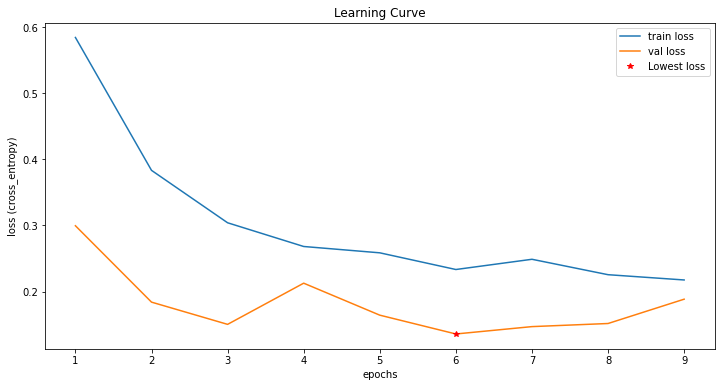

In [ ]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

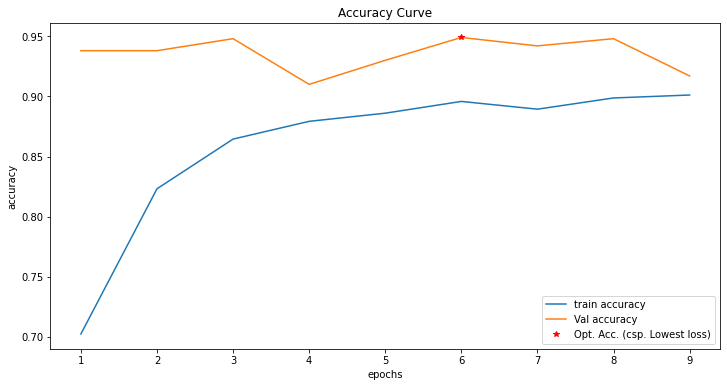

In [ ]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

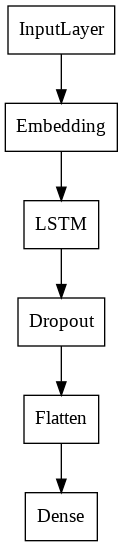

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (BLSTM) Model 


In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= Bidirectional(LSTM(units=32, return_sequences=True, return_state=False)), 
                       dropout=0.2, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 84)]              0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 84, 300)           9177600   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 84, 64)            85248     
_________________________________________________________________
dropout_20 (Dropout)         (None, 84, 64)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 5376)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10754     
Total params: 9,273,602
Trainable params: 96,002
Non-trainable params: 

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y, class_weight=None,
                               batch_size=500, epochs=15)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/15
19/19 [==============================] - 20s 844ms/step - loss: 0.5744 - accuracy: 0.6810 - val_loss: 0.2263 - val_accuracy: 0.9110

Testing loss: 0.2263077050447464, acc: 0.9110000133514404

Epoch 2/15
19/19 [==============================] - 12s 642ms/step - loss: 0.3598 - accuracy: 0.8416 - val_loss: 0.2345 - val_accuracy: 0.9070

Testing loss: 0.23447011411190033, acc: 0.9070000052452087

Epoch 3/15
19/19 [==============================] - 12s 644ms/step - loss: 0.2957 - accuracy: 0.8648 - val_loss: 0.1955 - val_accuracy: 0.9190

Testing loss: 0.19551408290863037, acc: 0.9190000295639038

Epoch 4/15
19/19 [==============================] - 12s 645ms/step - loss: 0.2583 - accuracy: 0.8794 - val_loss: 0.1618 - val_accuracy: 0.9380

Testing loss: 0.16178658604621887, acc: 0.9380000233650208

Epoch 5/15
19/19 [==============================] - 12s 648ms/step - loss: 0.2630 - accuracy: 0.8756 - val_loss: 0.1538 - val_accuracy: 0.9380

Testing loss: 0.15381371974945068, acc: 0

In [ ]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)

1/1 [==============================] - 1s 664ms/step - loss: 0.1614 - accuracy: 0.9440


[0.16137829422950745, 0.9440000057220459]

In [ ]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.3750    0.4091    0.3913        44
      NOT_HS     0.9727    0.9686    0.9706       956

    accuracy                         0.9440      1000
   macro avg     0.6738    0.6889    0.6810      1000
weighted avg     0.9464    0.9440    0.9452      1000



In [ ]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

2/2 [==============================] - 1s 605ms/step - loss: 0.1391 - accuracy: 0.9475


[0.1391032189130783, 0.9474999904632568]

In [ ]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.4787    0.4455    0.4615       101
      NOT_HS     0.9706    0.9742    0.9724      1899

    accuracy                         0.9475      2000
   macro avg     0.7247    0.7099    0.7170      2000
weighted avg     0.9458    0.9475    0.9466      2000



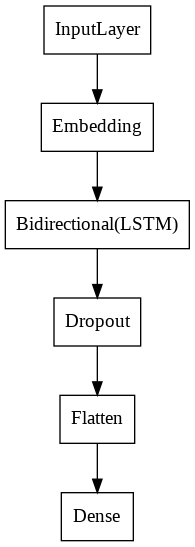

In [ ]:
plot_model(model, to_file='RNN_BLSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (GRU) Model


In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= GRU(units=16, return_sequences=True, return_state=False), 
                       dropout=0.5, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 84)]              0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 84, 300)           9177600   
_________________________________________________________________
gru_5 (GRU)                  (None, 84, 16)            15264     
_________________________________________________________________
dropout_17 (Dropout)         (None, 84, 16)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 2690      
Total params: 9,195,554
Trainable params: 17,954
Non-trainable params: 

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y, class_weight=None,
                               batch_size=500, epochs=15)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/15
19/19 [==============================] - 7s 246ms/step - loss: 0.5819 - accuracy: 0.7140 - val_loss: 0.2668 - val_accuracy: 0.9450

Testing loss: 0.2667834162712097, acc: 0.9449999928474426

Epoch 2/15
19/19 [==============================] - 4s 215ms/step - loss: 0.3862 - accuracy: 0.8283 - val_loss: 0.1986 - val_accuracy: 0.9320

Testing loss: 0.19862277805805206, acc: 0.9319999814033508

Epoch 3/15
19/19 [==============================] - 4s 219ms/step - loss: 0.3182 - accuracy: 0.8586 - val_loss: 0.1707 - val_accuracy: 0.9310

Testing loss: 0.17070698738098145, acc: 0.9309999942779541

Epoch 4/15
19/19 [==============================] - 4s 210ms/step - loss: 0.2870 - accuracy: 0.8693 - val_loss: 0.1736 - val_accuracy: 0.9320

Testing loss: 0.17363819479942322, acc: 0.9319999814033508

Epoch 5/15
19/19 [==============================] - 4s 226ms/step - loss: 0.2870 - accuracy: 0.8656 - val_loss: 0.1696 - val_accuracy: 0.9300

Testing loss: 0.16962240636348724, acc: 0.9300

In [ ]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)

1/1 [==============================] - 0s 202ms/step - loss: 0.1908 - accuracy: 0.9350


[0.19081221520900726, 0.9350000023841858]

In [ ]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.3671    0.6591    0.4715        44
      NOT_HS     0.9837    0.9477    0.9654       956

    accuracy                         0.9350      1000
   macro avg     0.6754    0.8034    0.7185      1000
weighted avg     0.9566    0.9350    0.9436      1000



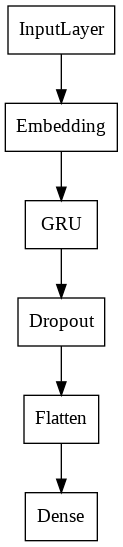

In [ ]:
plot_model(model, to_file='RNN_GRU_model.png', show_shapes=False, show_layer_names=False)

In [ ]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

2/2 [==============================] - 0s 188ms/step - loss: 0.2029 - accuracy: 0.9230


[0.2029138207435608, 0.9229999780654907]

In [ ]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.3520    0.6238    0.4500       101
      NOT_HS     0.9791    0.9389    0.9586      1899

    accuracy                         0.9230      2000
   macro avg     0.6655    0.7813    0.7043      2000
weighted avg     0.9475    0.9230    0.9329      2000



# CNN Model
[Colab Notebook](https://colab.research.google.com/drive/1_USllONVZIbf88aoPuQrzg9sg5HtY7K7)

# Combined CNN-RNN Models
[Colab Notebook](https://colab.research.google.com/drive/1LbZdJNvTzTqu6qLjDbOaeccJl36anJEw)